# Unified Model with Multiple Strategic Agents

Two naive agents

James Yu, 20 August 2025

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, X_0_1, b1, b2, e_weight):
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    delta = 0.9 # discount rate
    c_cost = 1 # message cost
    n = X_0_1.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c_cost * np.identity(n), c_cost * np.identity(n)] # message cost R = cI_n for some c under the new notation
    b_matrix_1 = np.array([
        [1-e_weight, 0.0],
        [0.0, e_weight]
    ])
    b_matrix_2 = np.array([
        [e_weight, 0.0],
        [0.0, 1-e_weight]
    ])
    B = [b_matrix_1, b_matrix_2] # B^l
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    return xs, rs, payoffs, historical_K
    #print(xs[0][-1])
    

In [7]:
X_0_1_numpy = np.array([[10.0, -5.0]], ndmin = 2).T

In [8]:
A_data = np.array([
    [1.0, 0.0],
    [0.0, 1.0]
])

# TEST 1: e = 0.01

In [9]:
b1_test = 1
b2_test = -1
e_test_1 = 0.01
xs_1, rs_1, payoffs_1, historical_K_1 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_1)

In [10]:
xs_1[0][-1]

array([[-0.0000326],
       [-1.9999674]])

In [11]:
xs_1[0][-1] + b1_test

array([[ 0.9999674],
       [-0.9999674]])

In [12]:
xs_1[1][-1] + b2_test

array([[ 0.9999674],
       [-0.9999674]])

In [13]:
historical_K_1[0]

[array([[1.59659721, 0.        ],
        [0.        , 1.18367315]]),
 array([[1.18367315, 0.        ],
        [0.        , 1.59659721]])]

# LIMIT OPINION:

In [14]:
(xs_1[0][-1] + b1_test).T

array([[ 0.9999674, -0.9999674]])

This is approximately the agendas.

# K1, K2:

In [15]:
historical_K_1[0][0] # THIS IS K1

array([[1.59659721, 0.        ],
       [0.        , 1.18367315]])

In [16]:
historical_K_1[0][1] # THIS IS K2

array([[1.18367315, 0.        ],
       [0.        , 1.59659721]])

# LIMIT MESSAGES:

In [17]:
rs_1[0][-1] # strategic agent 1

array([[0.00029031],
       [0.02874087]])

In [18]:
rs_1[1][-1] # strategic agent 2

array([[-0.02874087],
       [-0.00029031]])

# TEST 2: e = 0.5

In [19]:
e_test_2 = 0.5
xs_2, rs_2, payoffs_2, historical_K_2 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_2)

# LIMIT OPINION:

In [20]:
(xs_2[0][-1] + b1_test).T

array([[0., 0.]])

# K1, K2:

In [21]:
historical_K_2[0][0] # THIS IS K1

array([[1.67483714, 0.        ],
       [0.        , 1.67483714]])

In [22]:
historical_K_2[0][1] # THIS IS K2

array([[1.67483714, 0.        ],
       [0.        , 1.67483714]])

# LIMIT MESSAGES:

In [23]:
rs_2[0][-1] # strategic agent 1

array([[1.53376187],
       [1.53376187]])

In [24]:
rs_2[1][-1] # strategic agent 2

array([[-1.53376187],
       [-1.53376187]])

# TEST 3: when does it change from polarization to consensus?

In [25]:
xs_res_grid = []
for e_test_3 in np.linspace(0.01, 0.5, 100):
    xs_3, rs_3, payoffs_3, historical_K_3 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_3)
    xs_res_grid.append(xs_3[0][-1] + b1_test)

In [26]:
xs_res_grid[0]

array([[ 0.9999674],
       [-0.9999674]])

In [27]:
xs_res_grid[0][0]

array([0.9999674])

In [28]:
xs_res_grid[0][1][0]

np.float64(-0.9999674043374425)

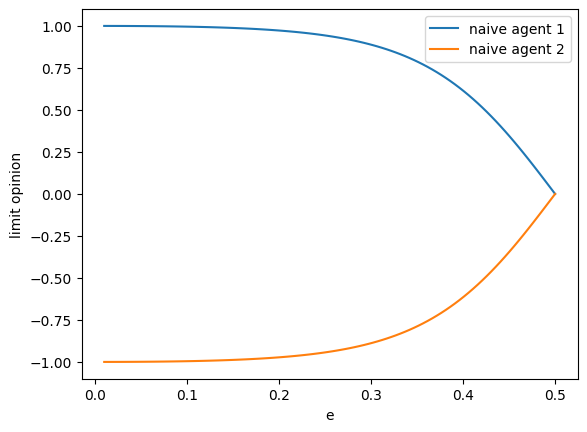

In [29]:
plt.plot(np.linspace(0.01, 0.5, 100), [xs_res[0][0] for xs_res in xs_res_grid], label = "naive agent 1")
plt.plot(np.linspace(0.01, 0.5, 100), [xs_res[1][0] for xs_res in xs_res_grid], label = "naive agent 2")
plt.xlabel("e")
plt.ylabel("limit opinion")
plt.legend()
plt.show()

# TEST 4: what if $e$ keeps going?

In [30]:
xs_res_grid_2 = []
for e_test_4 in np.linspace(0.01, 0.99, 100):
    xs_4, rs_4, payoffs_4, historical_K_4 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_4)
    xs_res_grid_2.append(xs_4[0][-1] + b1_test)

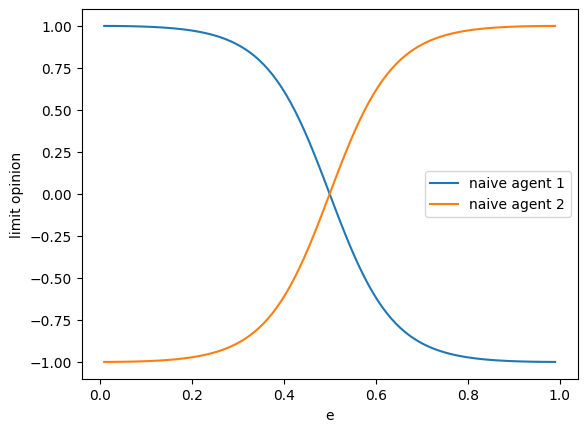

In [31]:
plt.plot(np.linspace(0.01, 0.99, 100), [xs_res[0][0] for xs_res in xs_res_grid_2], label = "naive agent 1")
plt.plot(np.linspace(0.01, 0.99, 100), [xs_res[1][0] for xs_res in xs_res_grid_2], label = "naive agent 2")
plt.xlabel("e")
plt.ylabel("limit opinion")
plt.legend()
plt.show()